<a href="https://colab.research.google.com/github/kusandriadi/wgan_batik/blob/main/generate_batik_WGANGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
import time
import tensorflow as tf
from IPython import display

In [2]:
#for targz
url = 'https://raw.githubusercontent.com/kusandriadi/wgan_batik/main/batik_nitik.tar.gz'
!curl {url} | tar xz

#for zip
#!wget https://raw.githubusercontent.com/kusandriadi/wgan_batik/main/Batik300.zip
#!unzip /content/Batik300.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9773k  100 9773k    0     0  8950k      0  0:00:01  0:00:01 --:--:-- 8958k


In [3]:
#load all *.jpg images from directory
image_paths = glob.glob('batik_nitik/*.jpg')

#count images
len(image_paths)

960

In [4]:
new_shape = (128, 128)

#process images
def load_reshape_normalize_image(image_path, new_shape):
    #read single image
    img = tf.io.read_file(image_path)
    #decode image to jpeg with 3 channels (RGB)
    img = tf.image.decode_jpeg(img,channels=3)

    # Resize the image
    img = tf.image.resize(img, new_shape)

    #normalize image to [-1,1]
    img = (tf.cast(img, tf.float32) / 127.5) - 1.0

    return img

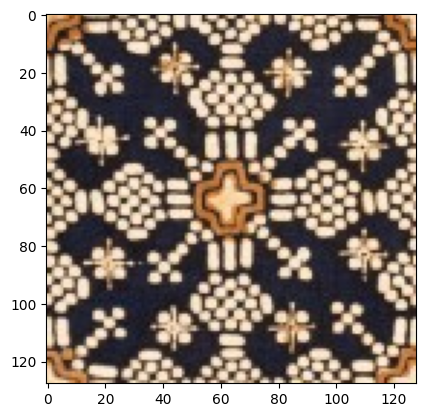

In [5]:
plt.imshow((load_reshape_normalize_image(image_paths[0], new_shape).numpy()+1)/2)

In [6]:
image_ds = tf.data.Dataset.from_tensor_slices(image_paths)
image_ds = image_ds.map(lambda x: load_reshape_normalize_image(x, new_shape), num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf.config.run_functions_eagerly(True)

In [7]:
BATCH_SIZE = 32
EPOCHS = 2000
LATENT_DIM = 100
num_examples_to_generate = 16
Shuffle_parameter = len(image_paths)

image_ds = image_ds.shuffle(Shuffle_parameter).batch(BATCH_SIZE)

In [8]:
def make_generator_model():
    model = keras.Sequential()
    model.add(layers.Dense(4 * 4 * 512, input_dim=LATENT_DIM))
    model.add(layers.Reshape((4, 4, 512)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation="tanh"))

    return model

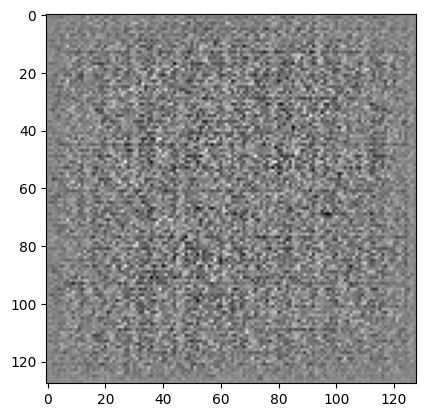

In [9]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')


In [10]:
def make_discriminator_model():
    model = keras.Sequential()
    model.add(layers.Input(shape=(128, 128, 3)))

    model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(256, kernel_size=4, strides=2, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(512, kernel_size=4, strides=2, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [11]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00013254]], shape=(1, 1), dtype=float32)


In [12]:
@tf.function
def gradient_penalty(real, fake, epsilon):
    #mixed_images = real * epsilon + fake * (1 - epsilon)
    mixed_images = fake + epsilon * (real - fake)
    with tf.GradientTape() as tape:
        tape.watch(mixed_images)
        mixed_scores = discriminator(mixed_images)


    gradient = tape.gradient(mixed_scores, mixed_images)[0]

    gradient_norm = tf.norm(gradient)
    penalty = tf.math.reduce_mean((gradient_norm - 1)**2)
    return penalty

def generator_loss(fake_output):
    gen_loss = -1. * tf.math.reduce_mean(fake_output)
    return gen_loss



def discriminator_loss(real_output, fake_output, gradient_penalty):
    c_lambda = 10
    loss = tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(real_output) + c_lambda * gradient_penalty
    return loss

#generator_optimizer = tf.keras.optimizers.Adam(1e-4)
#discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

generator_optimizer = tf.keras.optimizers.RMSprop(1e-4)
discriminator_optimizer = tf.keras.optimizers.RMSprop(5e-5)

#generator_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
#discriminator_optimizer = tf.keras.optimizers.RMSprop(0.0005)

In [13]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

seed = tf.random.normal([num_examples_to_generate, LATENT_DIM])

In [14]:
import tensorflow as tf

# Function to calculate SSIM
def calculate_ssim(real_image, generated_image):
    return tf.image.ssim(real_image, generated_image, 255)

In [15]:
def calculate_psnr(real_image, generated_image):
    return tf.image.psnr(real_image, generated_image, max_val=255)

In [16]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

    # Training discriminator 3 times for each batch
    for i in range(3):
        with tf.GradientTape() as disc_tape:
            generated_images = generator(noise, training=True)
            real_output = discriminator(images, training=True)
            fake_output = discriminator(generated_images, training=True)
            epsilon = tf.random.normal([BATCH_SIZE, 1, 1, 1], 0.0, 1.0)
            gp = gradient_penalty(images, generated_images, epsilon)
            disc_loss = discriminator_loss(real_output, fake_output, gp)

        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    ssim = calculate_ssim(images, generated_images);
    psnr = calculate_psnr(images, generated_images);

    return gen_loss.numpy(), disc_loss.numpy(), ssim, psnr

In [17]:
SSIM_TOTAL = []
PSNR_TOTAL = []

def train(dataset, epochs):
  generator_losses = []
  discriminator_losses = []

  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      if len(image_batch) == BATCH_SIZE:
        gen_loss, disc_loss, ssim, psnr = train_step(image_batch)
        generator_losses.append(gen_loss)
        discriminator_losses.append(disc_loss)
        SSIM_TOTAL.append(ssim)
        PSNR_TOTAL.append(psnr)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    # Plot the learning curve
    generate_and_save_plots(generator_losses, discriminator_losses, epoch+1)

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,epochs,seed)

In [18]:
def generate_and_save_images(model, epoch, test_input):
  image_result_dir = './image_result'
  if not os.path.isdir(image_result_dir):
    os.makedirs(image_result_dir)

  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      #plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.imshow((predictions[i, :, :, :3] + 1)/2)
      plt.axis('off')

  plt.savefig('image_result/image_at_epoch_{:04d}.jpg'.format(epoch))
  plt.show()

In [19]:
# Function to generate and save plot the learning curve
def generate_and_save_plots(generator_losses, discriminator_losses, epoch):
    learning_curve_dir = './learning_curve'
    os.path.isdir(learning_curve_dir)
    if not os.path.isdir(learning_curve_dir):
      os.makedirs(learning_curve_dir)

    plt.figure(figsize=(6, 3))
    plt.plot(generator_losses, label='Generator Loss')
    plt.plot(discriminator_losses, label='Discriminator Loss')
    plt.title('GAN Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.savefig('learning_curve/learning_curve_epoch_{:04d}.jpg'.format(epoch))
    plt.show()


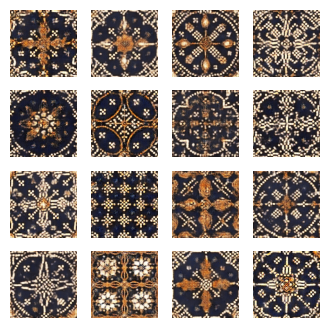

Time for epoch 1554 is 5.105452299118042 sec


KeyboardInterrupt: 

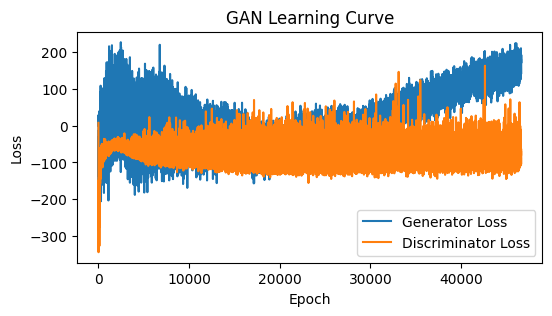

In [20]:
train(image_ds, EPOCHS)

In [ ]:
#print("Average SSIM", SSIM_TOTAL[len(SSIM_TOTAL) - 1])
#print("Average PSNR", PSNR_TOTAL[len(PSNR_TOTAL) - 1])

print("Average SSIM", tf.reduce_mean(SSIM_TOTAL))
print("Average PSNR", tf.reduce_mean(PSNR_TOTAL))

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_result/image_at_epoch_{:04d}.jpg'.format(epoch_no))

display_image(EPOCHS)

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('learning_curve/learning_curve_epoch_{:04d}.jpg'.format(epoch_no))

display_image(EPOCHS)